# Result - Analysis Debugging Validation Experiment

This experiment focuses on validating the effectiveness of analysis debugging techniques. The goal is to ensure that the implemented debugging methods accurately can acheive a good recall with datamodels and be performatic. Every step of the experiment is evaluated below.

## Main Results

* RAG:

In [2]:
import polars as pl
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from experiments.prompt_analysis_recall.run_rag import INSTRUCTIONS
from utils.metrics.calculate_metric import calculate_agg_metric

EXPERIMENTS = ["experiment_1", "experiment_4", "experiment_54", "experiment_61", "experiment_73"]
INSTRUCTIONS = ["instruction_0", "instruction_1", "instruction_2"]
ROOT = ".."

wiki = pl.read_ipc(f"../../../../data/wiki_dump2018_nq_open/processed/wiki.feather")
gold = pl.read_ipc(f"../../../../data/nq_open_gold/processed/dev.feather")


/home/caio.rhoden/miniconda3/envs/nq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-11 01:51:03 [__init__.py:216] Automatically detected platform cuda.


## RAG

In [8]:
## For each experiment, calculate rouge_l metric for each questions

LOAD = True

if not LOAD:

    rag_dfs_generations = []
    for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
            questions_path = f"{ROOT}/{exp}/questions.feather"
            for file in os.listdir(f"{ROOT}/{exp}/{inst}/generations"):
                    if file.startswith("rag_"):
                        rag_dfs_generations.append(calculate_agg_metric(
                            metrics=["rouge_l"],
                            generation_path=f"{ROOT}/{exp}/{inst}/generations/{file}",
                            reference_path=questions_path    ,
                            saving_path=None            
                        )
                        .with_columns([
                            pl.lit(exp).alias("experiment"),
                            pl.lit(inst).alias("instruction")
                        ]))

    rag_dfs_generations = pl.concat(rag_dfs_generations)
    rag_dfs_generations.write_ipc(f"rag_dfs_generations.feather")        
else:
    rag_dfs_generations = pl.read_ipc(f"rag_dfs_generations.feather")


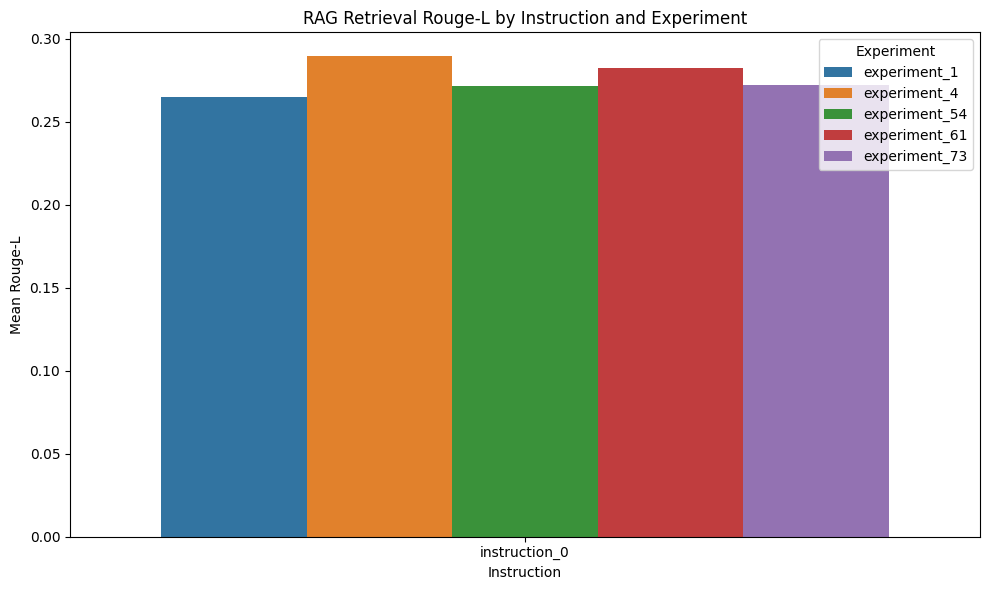

In [9]:
_rag = rag_dfs_generations.group_by(["experiment", "instruction"]).agg(pl.mean("mean")).sort(["experiment", "instruction"])

## bar plot per instruction with hue by experiment
plt.figure(figsize=(10, 6))
sns.barplot(data=_rag.to_pandas(), x="instruction", y="mean", hue="experiment")
plt.title("RAG Retrieval Rouge-L by Instruction and Experiment")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Experiment")
plt.tight_layout()
plt.show()

In [10]:
rag_dfs_generations.filter(pl.col("instruction") == "instruction_0").group_by(["experiment", "instruction"]).agg(pl.mean("mean")).sort(["experiment", "instruction"])


experiment,instruction,mean
str,str,f64
"""experiment_1""","""instruction_0""",0.264688
"""experiment_4""","""instruction_0""",0.28937
"""experiment_54""","""instruction_0""",0.271451
"""experiment_61""","""instruction_0""",0.282231
"""experiment_73""","""instruction_0""",0.272055


In [55]:
## gold per retrieval
ROOT = ""
for exp in EXPERIMENTS:
    _path = f"{exp}"
    docs_to_retrieve = json.load(open(f"{_path}/instruction_0/retrieval/rag_retrieval_indexes.json", "r"))
    questions = pl.read_ipc(f"{_path}/questions.feather")
    count = 0
    for i in range(500):
        for idx in docs_to_retrieve[str(i)]:
            if idx == gold.filter(pl.col("idx") == questions[i]["idx"].to_list()[0])["idx_gold_in_corpus"].to_list()[0]:
                count += 1
    print(f"Experiment: {exp} - Gold founds: {count}")
        

    

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Experiment: experiment_1 - Gold founds: 0


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Experiment: experiment_4 - Gold founds: 0


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Experiment: experiment_54 - Gold founds: 0


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Experiment: experiment_61 - Gold founds: 0


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Experiment: experiment_73 - Gold founds: 0


## Datamodels Generation

In [3]:
LOAD = False
EXPERIMENTS = ["experiment_1", "experiment_4", "experiment_54", "experiment_61", "experiment_73"]
INSTRUCTIONS = ["instruction_0", "instruction_1", "instruction_2"]

if not LOAD:
    
    datamodels_dfs_generations = []
    for exp in EXPERIMENTS:
        for inst in INSTRUCTIONS:
            questions_path = f"{ROOT}/{exp}/questions.feather"
            for file in os.listdir(f"{ROOT}/{exp}/{inst}/generations"):
                    if file.startswith("instruction"):
                        datamodels_dfs_generations.append(calculate_agg_metric(
                            metrics=["rouge_l"],
                            generation_path=f"{ROOT}/{exp}/{inst}/generations/{file}",
                            reference_path=questions_path    ,
                            saving_path=None            
                        )
                        .with_columns([
                            pl.lit(exp).alias("experiment"),
                            pl.lit(inst).alias("instruction")
                        ]))
                

    datamodels_dfs_generations = pl.concat(datamodels_dfs_generations)
    datamodels_dfs_generations.write_ipc(f"datamodels_dfs_generations.feather")        
else:
    datamodels_dfs_generations = pl.read_ipc(f"datamodels_dfs_generations.feather")

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Using the latest cached version of the module from /home/caio.rhoden/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--rouge/b01e0accf3bd6dd24839b769a5fda24e14995071570870922c71970b3a6ed886 (last modified on Wed Oct 16 22:50:24 2024) since it couldn't be found locally at evaluate-metric--rouge, or remotely on the Hugging Face Hub.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to no

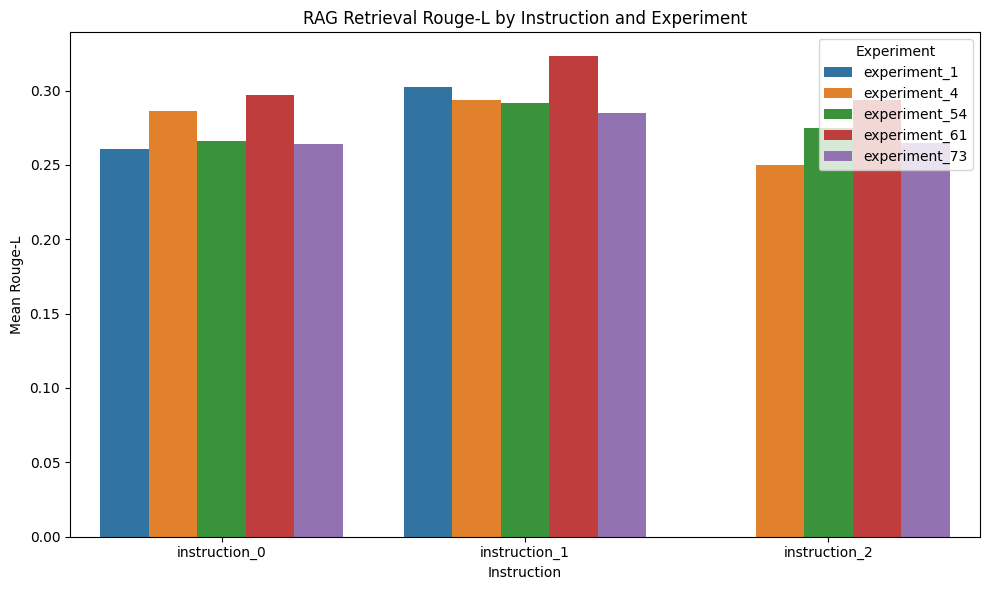

In [4]:

pl.Config.set_tbl_rows(15)
_dat = datamodels_dfs_generations.group_by(["experiment", "instruction"]).agg(pl.mean("mean")).sort(["experiment", "instruction"])
plt.figure(figsize=(10, 6))
sns.barplot(data=_dat.to_pandas(), x="instruction", y="mean", hue="experiment")
plt.title("RAG Retrieval Rouge-L by Instruction and Experiment")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Instruction")
plt.legend(title="Experiment")
plt.tight_layout()
plt.show()

In [6]:
datamodels_dfs_generations.group_by(["instruction"]).agg(pl.mean("mean")).sort(["instruction"])


instruction,mean
str,f64
"""instruction_0""",0.274817
"""instruction_1""",0.299208
"""instruction_2""",0.270764
